In [1]:
import glob
import os
import pandas as pd
import math

import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras import optimizers, regularizers, activations 
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical 

import librosa
import librosa.display
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram

from livelossplot.inputs.tf_keras import PlotLossesCallback
from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import auc, confusion_matrix, balanced_accuracy_score, plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import class_weight


%matplotlib inline
import seaborn as sns
import plotly.graph_objects as go
plt.style.use('ggplot')

In [2]:
# constants
DROPOUT= 0.45
EPOCHS=100
BATCH_SIZE = 64
ACTIVATION_FUNCTION = 'relu'
LEARNING_RATE = 0.001  # lr=learning_rate, decay=decay_rate
DECAY_RATE = 0.000015
MOMENT = 0.9


# constants
NP_TRAIN_DATASET = 'dataset_train.npy'
NP_TEST_DATASET = 'dataset_test.npy'
DATA_PATH = "../../../datasets/FSD50K/"
EMOTIONS_DATASET = 'csv_datasets/emotions.csv'

In [3]:
#para melhor gestão memória GPU por parte do tensorflow

def set_keras_backend(backend):
    print("A acertar o backend e libertar memória da grafica")
    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        importlib.reload(K)
        assert K.backend() == backend
    if backend == "tensorflow":
        # Allow memory growth for the GPU
        physical_devices = tf.config.experimental.list_physical_devices('GPU')
        print(physical_devices)
        tf.config.experimental.set_memory_growth(physical_devices[0], True)


def limit_mem():
    K.get_session().close()
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))

set_keras_backend("tensorflow")

A acertar o backend e libertar memória da grafica
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


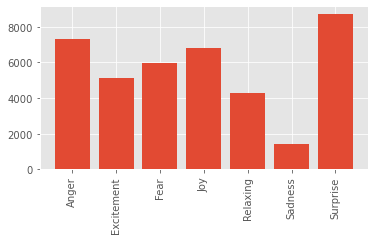

x (39566, 193)
y (39566,)


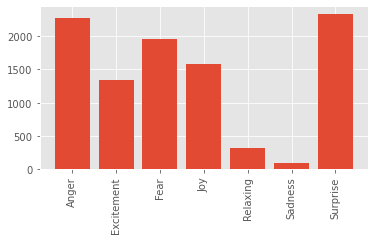

x (9897, 193)
y (9897,)


In [5]:
def load_data(np_dataset, emotion_dataset):
    std = StandardScaler()
    data = pd.DataFrame(np.load(np_dataset,allow_pickle= True))
    data.columns = ['mfccs', 'chroma', 'mel', 'contrast', 'tonnetz', 'label']
    emotions = pd.read_csv(emotion_dataset, sep=';')
    new_data = pd.merge(emotions, data, on='label')
    #emotions = emotions.drop(['labels', 'Cluster Labels'], axis=1)
    #new_data = data.join(emotions)
    #print(new_data.head())
    #data = pd.merge(data, emotions, on="label")
    mfcss = np.array(new_data.mfccs.tolist())
    chroma = np.array(new_data.chroma.tolist())
    mel = np.array(new_data.mel.tolist())
    contrast = np.array(new_data.contrast.tolist())
    tonnetz = np.array(new_data.tonnetz.tolist())
    features = np.hstack([mfcss, chroma, mel, contrast, tonnetz])
    X = np.array(features)
    std.fit(X)
    Y = np.array(new_data.emotion.tolist())
    
    unique, counts = np.unique(Y, return_counts=True)
    
    plt.figure(figsize=(20, 3))
    plt.subplot(131)
    plt.bar(unique, counts)
    plt.xticks(rotation=90)
    
    plt.show()
    
    X.shape, Y.shape, X[0].reshape(1,X[0].shape[0]).shape
    
    lb = LabelEncoder()
    print('x',X.shape)
    print('y',Y.shape)
    return (X, Y)
    
(x_train, y_train) = load_data(NP_TRAIN_DATASET, EMOTIONS_DATASET)
(x_test, y_test) = load_data(NP_TEST_DATASET, EMOTIONS_DATASET)

In [6]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

{0: 0.775241491466975, 1: 1.108943636312677, 2: 0.9506030464658114, 3: 0.8275674545074252, 4: 1.3218628892155553, 5: 3.980482897384306, 6: 0.6492402612319911}


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=['Anger' 'Excitement' 'Fear' 'Joy' 'Relaxing' 'Sadness' 'Surprise'], y=['Joy' 'Joy' 'Joy' ... 'Anger' 'Anger' 'Anger'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [7]:
lb = LabelEncoder()

y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))
print(y_train.shape)
print(y_test.shape)

(39566, 7)
(9897, 7)


In [8]:
# neural network dimensions
n_dim = x_train.shape[1]
n_classes = y_train.shape[1]
print ("Features:", n_dim, "Classes:", n_classes)

Features: 193 Classes: 7


In [9]:
def definetrainfunctions(op):
    if op == "Adam":
        function_optmizer = optimizers.Adam(lr=LEARNING_RATE, decay=DECAY_RATE)
    elif op == "SGD":
        function_optmizer = optimizers.SGD(lr=LEARNING_RATE, decay=DECAY_RATE, momentum=MOMENT)
    print("Optimizer: " + str(function_optmizer))
    return function_optmizer

In [10]:
tf.random.set_seed(0)
np.random.seed(0)

function_optmizer=definetrainfunctions("Adam")

def mlp_model():
    model = Sequential()
    # layer 1
    model.add(Dense(n_dim, input_dim=n_dim, activation=ACTIVATION_FUNCTION))
    model.add(Dropout(DROPOUT))
    # layer 2
    #model.add(Dense(400, activation=ACTIVATION_FUNCTION))
    #model.add(Dropout(DROPOUT))
    # layer 2
    #model.add(Dense(300, activation=ACTIVATION_FUNCTION))
    #model.add(Dropout(DROPOUT))
    # layer 3
    model.add(Dense(100, activation=ACTIVATION_FUNCTION))
    model.add(Dropout(DROPOUT))
    # layer 3
    model.add(Dense(50, activation=ACTIVATION_FUNCTION))
    model.add(Dropout(DROPOUT))
    # output layer
    model.add(Dense(n_classes, activation='softmax'))

    return model

Optimizer: <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f51addd3590>


In [11]:
model = mlp_model()

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 193)               37442     
_________________________________________________________________
dropout (Dropout)            (None, 193)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               19400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 3

In [13]:
model.compile(loss='categorical_crossentropy', optimizer=function_optmizer, metrics=['accuracy'])

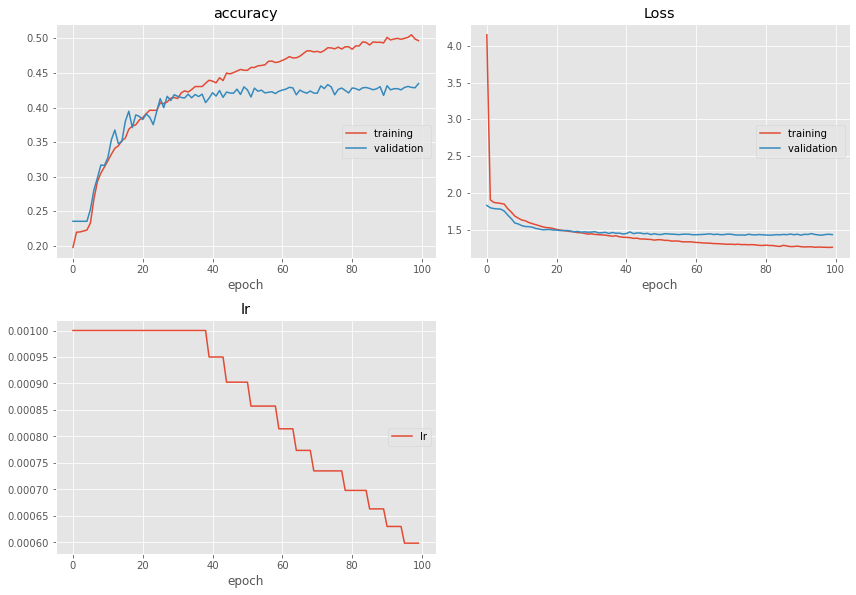

accuracy
	training         	 (min:    0.198, max:    0.505, cur:    0.497)
	validation       	 (min:    0.235, max:    0.435, cur:    0.435)
Loss
	training         	 (min:    1.261, max:    4.149, cur:    1.263)
	validation       	 (min:    1.427, max:    1.831, cur:    1.435)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
619/619 [==============================] - 2s 4ms/step - loss: 1.2625 - accuracy: 0.4967 - val_loss: 1.4352 - val_accuracy: 0.4346 - lr: 5.9874e-04
Scores:  [1.4351520538330078, 0.4345761239528656]
Erro modelo: 56.54%


In [14]:
earlystop = EarlyStopping(monitor='val_acc', patience=5, verbose=1, mode='auto')

m1 = ModelCheckpoint('best_MPLEmotions_model'+ ".h5", monitor='val_loss', verbose=0,
                         save_best_only=True, save_weights_only=False, mode='auto')
m4 = ModelCheckpoint('best_MPLEmotions_model_weights'+ ".hdf5", monitor='val_loss', verbose=0,
                         save_best_only=True, save_weights_only=True, mode='auto')

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',factor=0.95, patience=3,cooldown=3,min_lr=0.00001,verbose=1)


history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[earlystop, reduce_learning_rate, m1, PlotLossesCallback()])


# Avaliação final com os casos de teste
scores = model.evaluate(x_test, y_test, verbose=0)
print('Scores: ', scores)
print("Erro modelo: %.2f%%" % (100-scores[1]*100))

In [15]:
def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return indices

In [16]:
def truncate(n, decimals=0):
    multiplier = 10 ** decimals
    return int(n * multiplier) / multiplier

In [19]:
def print_series_prediction(sound, label):
    sounds = []
    first_preds = []
    first_percent = []
    second_preds = []
    second_percent = []
    third_preds = []
    third_percent = []
    for i in range(len(sound)): #para imprimir tabela de previsoes
        predictions = model.predict(sound)
        predic = largest_indices(predictions[i], 3)
        percentage = predictions[i][predic]
        
        sounds.append(label[i])

        first_preds.append(lb.inverse_transform(predic)[0])
        first_percent.append(truncate(percentage[0],3))
        second_preds.append(lb.inverse_transform(predic)[1])
        second_percent.append(truncate(percentage[1],3))
        third_preds.append(lb.inverse_transform(predic)[2])
        third_percent.append(truncate(percentage[2],3))
       
    data = {'y_test':  sounds,
            'first_pred': first_preds,
            'first_percent': first_percent,
            'second_pred': second_preds,
            'second_percent': second_percent,
            'third_pred': third_preds,
            'third_percent': third_percent
           }
    df = pd.DataFrame(data)
    fig = go.Figure(data=[go.Table(
    header=dict(values=list(df.columns),
                fill_color='lavender',
                align='center'),
    cells=dict(values=[df.y_test, df.first_pred, df.first_percent,
                       df.second_pred, df.second_percent, df.third_pred, df.third_percent
                      ],
               #fill_color='lightgrey',
               fill=dict(color=['lightgrey', 'white']),
               align='center'))])

    fig.show()
    return df

y_teste = np.argmax(y_test, axis= 1)
df = print_series_prediction(x_test,  lb.inverse_transform(y_teste))

In [ ]:
y_treino = np.argmax(y_train, axis= 1)
#print(y_teste)
print_series_prediction(x_train, lb.inverse_transform(y_treino))